# Kalman Filter for Motion Structure Identification

## Problem setup
![soccer](https://www.dutchreferee.com/wp-content/uploads/2019/03/tottenham-arsenal-offside-before-foul.jpg)
**Motion structure** is ubiquitous in real-world scenes. In a soccer match, players can move freely on the pitch. When a defender marks an opponent tightly, they move in a cluster. All the (outfield) players also have a global movement following the ball.

Previous work shows that people can make use of structural relations among velocities of objects in visual scenes to track objects and predict the position of occluded objects (Bill, Pailian, Gershman, & Drugowitsch, 2019). To further study **whether humans can explicitly identify specific motion structures**, we compare how humans and Kalman filters match known motion structures with a segment of a 1d random walks of 3 dots on a circle. 3 objects can only have **4 motion structures** as illustrated below:
- **IND**: Only 3 **independent** motion sources. Johannes, Qiao, and Sichao go to grab their favorite food independently.
- **GLO**: 1 **global** motion source + 3 independent motion sources. Johannes, Qiao, and Sichao go to lunch together.
- **CLU**: 2 objects in a **cluster**. 1 cluster motion source + 3 independent motion sources. Johannes and Qiao go to lunch together, while Sichao wants to fix a bug.
- **SDH**: **Deep hierarchy**. 1 global motion source + 1 cluster motion source + 3 independent motion sources. Sichao has fixed the bug and catches up. Johannes and Qiao are chatting ahead on the pavement when Sichao rides his bike on the bike lane.

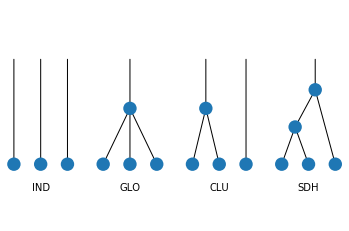

In [2]:
def draw_structure(ax, bbox, structure, zorder=0):
    """
    visualizes a motion structure inside a given bbox on a given axes
    :param ax: where the structures will be drawn
    :type ax: matplotlib.axes.Axes
    :param bbox: (x, y, w, h) bounding box inside which the structure will be drawn
    :type bbox: (float, float, float, float)
    :param structure: the structure to be drawn
    :type structure: str
    :param zorder: drawing order of the patches composing the structure
    :type zorder: int
    """
    from matplotlib.patches import Circle, ConnectionPatch
    x, y, w, h = bbox
    r = w / 10
    centers = [[(x + dx, y + dy) for (dx, dy) in layer] for layer in nodes[structure](r, h)]
    lines = edges[structure](centers)
    for layer in centers[:-1]:
        for c in layer:
            ax.add_patch(Circle(c, r, zorder=zorder))
    for c1, c2 in lines:
        ax.add_patch(ConnectionPatch(c1, c2, 'data', 'data', zorder=zorder-1))


nodes = {
    'IND': lambda r, h:
        [[(r, r), (r * 5, r), (r * 9, r)],
         [(r, h), (r * 5, h), (r * 9, h)]],
    'GLO': lambda r, h:
        [[(r, r), (r * 5, r), (r * 9, r)],
         [(r * 5, r + h / 2)],
         [(r * 5, h)]],
    'CLU': lambda r, h:
        [[(r, r), (r * 5, r), (r * 9, r)],
         [(r * 3, r + h / 2)],
         [(r * 3, h), (r * 9, h)]],
    'SDH': lambda r, h:
        [[(r, r), (r * 5, r), (r * 9, r)],
         [(r * 3, r + h / 3)],
         [(r * 6, r + h * 2 / 3)],
         [(r * 6, h)]],
}

edges = {
    'IND': lambda c:
        [(c[0][0], c[1][0]), (c[0][1], c[1][1]), (c[0][2], c[1][2])],
    'GLO': lambda c:
        [(c[0][0], c[1][0]), (c[0][1], c[1][0]), (c[0][2], c[1][0]),
         (c[1][0], c[2][0])],
    'CLU': lambda c:
        [(c[0][0], c[1][0]), (c[0][1], c[1][0]),
         (c[1][0], c[2][0]), (c[0][2], c[2][1])],
    'SDH': lambda c:
        [(c[0][0], c[1][0]), (c[0][1], c[1][0]),
         (c[1][0], c[2][0]), (c[0][2], c[2][0]),
         (c[2][0], c[3][0])],
}

if __name__ == '__main__':
    # unit test
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.text(0.15, -0.05, 'IND', ha='center', va='top')
    draw_structure(ax, (0, 0, 0.3, 0.5), 'IND')
    ax.text(0.55, -0.05, 'GLO', ha='center', va='top')
    draw_structure(ax, (0.4, 0, 0.3, 0.5), 'GLO')
    ax.text(0.95, -0.05, 'CLU', ha='center', va='top')
    draw_structure(ax, (0.8, 0, 0.3, 0.5), 'CLU')
    ax.text(1.35, -0.05, 'SDH', ha='center', va='top')
    draw_structure(ax, (1.2, 0, 0.3, 0.5), 'SDH')
    ax.axis('off')
    ax.axis('equal')
    ax.axis([0, 1.5, 0, 0.5])
    plt.show()

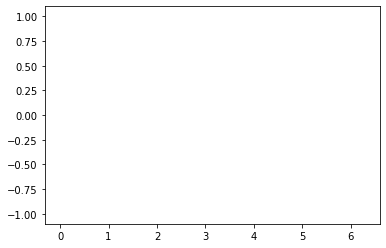

In [4]:
%matplotlib inline
"""
A simple example of an animated plot
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def animate(i):
    line.set_ydata(np.sin(x + i/10.0))  # update the data
    return line,


# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init,
                              interval=25, blit=True)
plt.show()

## Kalman filter
**Kalman filtering** is a recursive estimator that models a dynamical system by incorporating optional control inputs, system dynamics, and multiple noisy sequential measurements into estimating the joint probability distribution over some unknown variables for each timeframe.

![overview](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Basic_concept_of_Kalman_filtering.svg/600px-Basic_concept_of_Kalman_filtering.svg.png)
<p style="text-align: center; font-style: italic;">Fig. 1: Overview of Kalman filtering (different notations)</p>

### Prediction step

&nbsp; | &nbsp; | &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; | &nbsp;&nbsp;&nbsp;&nbsp; | &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
:--- |:--- |:---:|:--- |:---  
->|$\mathbf{z}_t$|-$\mathbf{F}_{t+1},\mathbf{B}_{t+1},\mathbf{Q}_{t+1}$->|$\mathbf{z}_{t+1}$|-$\mathbf{F}_{t+2},\mathbf{B}_{t+2},\mathbf{Q}_{t+2}$->
$\mathbf{H}_t,\mathbf{R}_t$|&darr;&nbsp;|$\mathbf{H}_{t+1}, \mathbf{R}_{t+1}$|&darr;&nbsp;&nbsp;&nbsp;&nbsp;|
&nbsp;|$\mathbf{x}_t$|&nbsp;|$\mathbf{x}_{t+1}$|&nbsp;

<p style="text-align: center; font-style: italic;">Fig. 2: Overview of Kalman filtering</p>

The Kalman filters are based on linear dynamical systems discretized in the time domain, modeled on a Markov chain built on linear operators perturbed by errors that may include Gaussian noise.

At each time increment $t-1 \to t$, a linear operator, the state transition model $\mathbf{F}_t$, is applied to the vectorized system state $\mathbf{z}_{t-1}$ to generate the new state $\mathbf{z}_{t}$, with noise $\mathbf{w}_t \sim \mathcal{N}(0, \mathbf{Q}_t)$ mixed in, and optionally some external input mapped by the control-input model $\mathbf{B}_t$ from control vector $\mathbf{u}_t$ on the system:
$$\mathbf{z}_{t} = \mathbf{F}_t\mathbf{z}_{t-1}+\mathbf{B}_t\mathbf{u}_t+\mathbf{w}_t$$

At time $t$, another linear operator, the observation model $\mathbf{H}_t$, mixed with Gaussian white noise $\mathbf{v}_t \sim \mathcal{N}(0,\mathbf{R}_t)$ generates the observed outputs $\mathbf{x}_t$ from the hidden state $\mathbf{z}_t$:  
$$\mathbf{x}_t=\mathbf{H}_t\mathbf{z}_t+\mathbf{v}_t$$

The initial state, and the noise vectors at each step $\{\mathbf{z}_0, \mathbf{w}_0, \dots, \mathbf{w}_t, \mathbf{v}_0, \dots, \mathbf{v}_t\}$ are all assumed to be mutually independent.

Notations: given observations up to time $\tau$, denote the estimate of the state at $t$ as $\hat{\mathbf{x}}_{t|\tau}$, the error covariance as $\mathbf{P}_{t|\tau}$, and the residual as $\tilde{\mathbf{y}}_{t|\tau}$.

The predicted (_a priori_) state estimate:
$$\hat{\mathbf{z}}_{t|t-1} = \mathbf{F}_{t}\hat{\mathbf{z}}_{t-1|t-1}+\mathbf{B}_{t}\mathbf{u}_{t}$$
The predicted (_a priori_) error covariance:
$$\mathbf{P}_{t|t-1}=\mathbf{F}_{t}\mathbf{P}_{t-1|t-1}\mathbf{F}_{t}^{\textsf{T}}+\mathbf{Q}_{t}$$

### Update step
With new observation, the Kalman filter updates its current state estimate to an average of the predicted and measured state, weighted on their certainty. The relative weight given to the measurement and current state estimate is called the **Kalman gain**.

Innovation pre-fit residual:
$$\tilde{\mathbf{y}}_{t|t-1} = \mathbf{x}_t - \mathbf{H}_{t}\hat{\mathbf{z}}_{t|t-1}$$
Innovation pre-fit residual covariance:
$$\mathbf{S}_t = \mathbf{H}_{t}\mathbf{P}_{t|t-1}\mathbf{H}_{t}^{\textsf{T}}+\mathbf{R}_{t}$$
Optimal Kalman gain:
$$\mathbf{K}_{t}=\mathbf{P}_{t|t-1}\mathbf{H}_{t}^{\textsf{T}}\mathbf {S}_{t}^{-1}$$
Updated (_a posteriori_) state estimate:
$$\hat{\mathbf{z}}_{t|t}={\hat{\mathbf{z}}}_{t|t-1}+\mathbf{K}_{t}{\tilde{\mathbf{y}}}_{t|t-1}$$
Updated (_a posteriori_) estimate covariance:
$$\mathbf{P}_{t|t}=(\mathbf{I}-\mathbf{K}_{t}\mathbf{H} _{t})\mathbf{P}_{t|t-1}$$
Measurement post-fit residual:
$${\tilde{\mathbf{y}}}_{t|t}=\mathbf{x}_{t}-\mathbf{H}_{t}{\hat {\mathbf{z}}}_{t|t}$$

### Bayesian view
Resembling recursive Bayesian estimation, the system state is assumed to be an unobserved Markov process, and the measurements are the observed states of a hidden Markov model.
$$p(\mathbf{z}_t|\mathbf{z}_0,\dots,\mathbf{z}_{t-1})=p(\mathbf{z}_t|\mathbf{z}_{t-1})=\mathcal{N}(\mathbf{F}_{t}\mathbf{z_{t-1}}+\mathbf{B}_{t}\mathbf{u}_{t}, \mathbf{Q}_{t})$$
$$p(\mathbf{x}_t|\mathbf{z}_0,\dots,\mathbf{z}_{t})=p(\mathbf{x}_t|\mathbf{z}_{t})=\mathcal{N}(\mathbf{H}_t\mathbf{z}_t,\mathbf{R}_t)$$
$$p(\mathbf{z}_{t}|\mathbf{x}_{0},\dots,\mathbf{x}_{t})=\frac{p(\mathbf{x}_{t}|\mathbf{z}_{t})p(\mathbf{z}_{t}|\mathbf{x}_{0},\dots,\mathbf{x}_{t-1})}{p(\mathbf{x}_{t}|\mathbf{x}_{0},\dots,\mathbf{x}_{t-1})}=\frac{p(\mathbf{x}_{t}|\mathbf{z}_{t})\int p(\mathbf{z}_{t}|\mathbf{z}_{t-1})p(\mathbf{z}_{t-1}|\mathbf{x}_{0},, \dots, \mathbf{x}_{t-1})d\mathbf{z}_{t-1}}{\int p(\mathbf{x}_{t}|\mathbf{z}_{t})p(\mathbf{z}_{t}|\mathbf{x}_{0},, \dots, \mathbf{x}_{t-1})d\mathbf{z}_{t}}$$
$$p(\mathbf{z}_{t-1}|\mathbf{x}_{0},, \dots, \mathbf{x}_{t-1})=\mathcal{N}(\hat{\mathbf{z}}_{t-1}, \mathbf{P}_{t-1})$$

Generative model:
1. Sample a hidden state $\mathbf{z}_{0}$ from the Gaussian prior distribution
$$p(\mathbf{z}_{0})=\mathcal{N}({\hat{\mathbf{z}}}_{0|0},\mathbf{P}_{0|0})$$
2. Sample an observation $\mathbf{x}_{0}$ from the observation model 
$$p(\mathbf{x}_{0}|\mathbf{z}_{0})=\mathcal{N}(\mathbf{H}_0\mathbf{z}_0,\mathbf{R}_0)$$
3. For $t=1,2,3,\dots$, do
    1. Sample the next hidden state $\mathbf{z}_{t}$ from the transition model
    $$p(\mathbf{z}_{t}|\mathbf{z}_{t-1})={\mathcal{N}}(\mathbf{F}_{t}\mathbf{z}_{t-1}+\mathbf{B}_{t}\mathbf{u}_{t},\mathbf {Q}_{t})$$
    2. Sample an observation $\mathbf{x}_{t}$ from the observation model
    $$p(\mathbf{x}_{t}|\mathbf{z}_{t})=\mathcal{N}(\mathbf{H}_{t}\mathbf{z}_{t}, \mathbf{R}_{t})$$
    
Marginal likelihood:  
$$\begin{aligned}
p(\mathbf{x})
&=\prod_{t=0}^{T}p(\mathbf{x}_{t}|\mathbf{x}_{t-1}, \dots, \mathbf{x}_{0}) \\
&=\prod_{t=0}^{T}\int p(\mathbf{x} _{t}|\mathbf{z}_{t})p(\mathbf{z}_{t}|\mathbf{x}_{0},\dots,\mathbf{x}_{t-1})d\mathbf{z}_{t}\\
&=\prod_{t=0}^{T}\int\mathcal{N}(\mathbf{x}_{t};\mathbf{H}_{t}\mathbf {z}_{t},\mathbf{R}_{t}){\mathcal{N}}(\mathbf{z}_{t};{\hat{\mathbf{z} }}_{t|t-1},\mathbf{P}_{t|t-1})d\mathbf{z}_{t}\\
&=\prod_{t=0}^{T}\mathcal{N}(\mathbf{x}_{t};\mathbf{H}_{t}{\hat{\mathbf{z}}}_{t|t-1},\mathbf{R}_{t}+\mathbf{H}_{t}\mathbf{P}_{t|t-1}\mathbf{H}_{t}^{\textsf{T}})\\
&=\prod_{t=0}^{T}\mathcal{N}(\mathbf{x}_{t};\mathbf{H}_{t}{\hat{\mathbf{z}}}_{t|t-1},\mathbf{S}_{t})\\
&=\prod_{t=0}^{T}\mathcal{N}(\tilde{\mathbf{y}}_{t|t-1};0,\mathbf{S}_{t})
\end{aligned}$$
_log_ marginal likelihood $\ell = \log p(\mathbf{x})$ recursive update rule:
$$\ell^{(t)}=\ell ^{(t-1)}-{\frac {1}{2}}({\tilde{\mathbf{y}}}_{t|t-1}^{\textsf{T}}\mathbf{S}_{t}^{-1}{\tilde {\mathbf{y}}}_{t|t-1}+\log|\mathbf{S}_{t}|+d_{y}\log 2\pi)$$
where $d_{y}$ is the dimension of the measurement vector. By convention $\mathcal{\ell}^{(-1)} = 0$.

## References  
Wikipedia - Kalman filter: https://en.wikipedia.org/wiki/Kalman_filter

## The state-transition model F and the covariance of the process noise Q
The angular motion system has no control input. Its state at time $t$ consists of dot location $\phi_t$ and angular velocity $\omega_t$:
$$
\begin{pmatrix}
\phi_t \\
\omega_t
\end{pmatrix}
+
d\begin{pmatrix}
\phi_t \\
\omega_t
\end{pmatrix}
=
\begin{pmatrix}
\phi_{t+dt} \\
\omega_{t+dt}
\end{pmatrix}
=
\mathbf{F}_{t+dt}
\begin{pmatrix}
\phi_{t} \\
\omega_{t}
\end{pmatrix}
+
\mathbf{w}_{t+dt}
$$

The Itô stochastic differential equation of the angular motion is
$$
d\begin{pmatrix}
\phi_t \\
\omega_t
\end{pmatrix}
=
\begin{pmatrix} 
\mathbf{0} & \mathbf{I} \\
\mathbf{0} & -\mathbf{I}/\tau_\omega 
\end{pmatrix}
\begin{pmatrix}
\phi_t \\
\omega_t
\end{pmatrix}
dt
+
\begin{pmatrix} 
\mathbf{0} & \mathbf{0} \\
\mathbf{0} & \mathbf{L}
\end{pmatrix}
d\mathbf{W}_t
=
\mathbf{F}_\phi
\begin{pmatrix}
\phi_t \\
\omega_t
\end{pmatrix}
dt
+
\mathbf{D}_\phi
d{W}_t
$$
where $\tau_\omega$ is the time constant for significant changes in angular velocities and the vector of Wiener processes $\mathbf{W}_t$ satisfies $d\mathbf{W}_t \sim \mathcal{N}(0, dt)$.

Therefore $\forall t$:
$$
\mathbf{F}_t
=
\mathbf{I}
+
\mathbf{F}_\phi
dt
$$
$$
\mathbf{Q}_t
=
\mathbf{D}_\phi
\mathbf{D}_\phi^\mathsf{T}
dt
$$


In [29]:
import numpy as np


def gen_L(glo, λ_I):
    B = np.array([
        [1, 1, 1, 0, 0, ],   # MOTION STRUCTURE COMPONENT MATRIX
        [1, 1, 0, 1, 0, ],   # each row describes one dot (N dots)
        [1, 0, 0, 0, 1, ],   # each column is a motion source (M sources)
        ], dtype=np.float64)
    volatility_factor = 4/3  # Makes the stimulus change more rapidly without affecting the covariance matrix
    speed_factor = 1.0
    λ_T = 2.                                                # total
    λ_G = np.sqrt(glo) * np.sqrt(max(0., λ_T**2 - λ_I**2))  # global
    λ_C = np.sqrt(max(0., λ_T**2 - λ_G**2 - λ_I**2))        # cluster
    λ_M = np.sqrt(max(0., λ_T**2 - λ_G**2))                 # maverick
    λ = speed_factor * np.sqrt(volatility_factor) * np.array([λ_G, λ_C, λ_I, λ_I, λ_M])
    L = B @ np.diag(λ)
    𝜏_𝜔 = 2. / volatility_factor
    return L, 𝜏_𝜔

In [30]:
class Dynamics:
    def __init__(self, L, 𝜏_𝜔):
        self.n, self.m = L.shape
        self.L = L
        self.𝜏_𝜔 = 𝜏_𝜔
        self.I = np.eye(self.n)

    def build_F_angular(self):
        F = np.zeros((self.n + self.n, self.n + self.n))
        F[:self.n, self.n:] = self.I
        F[self.n:, self.n:] = -self.I / self.𝜏_𝜔
        return F
        
    def build_D_angular(self):
        D = np.zeros((self.n + self.n, self.n + self.m))
        D[:self.n, self.n:] = self.L
        return D

In [32]:
d = Dynamics(*gen_L(0, 2))
print(d.build_F_angular())
print(d.build_D_angular())

[[ 0.          0.          0.          1.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.66666667 -0.         -0.        ]
 [ 0.          0.          0.         -0.         -0.66666667 -0.        ]
 [ 0.          0.          0.         -0.         -0.         -0.66666667]]
[[0.         0.         0.         0.         0.         2.30940108
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  2.30940108 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         2.30940108]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]


$\beta$